In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import simdna
from simdna import synthetic
import torch

from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, pearson_r, spearman_rho, rsquared
from tf_coop_simulation import background_frequency

# Initialize Model & Load Weights
This step assumes we've trained a counts regression model and have its weights stored in a .pt[h] file somewhere accessible.

In [3]:
n_conv_layers = 3
n_dense_layers = 3
n_outputs = 2
sequence_length = 100
filters = 15
filter_width = 7
dense_layer_width = 30

weights_fpath = '../dat/sim/cnn_counts_predictor.pt'
test_data_fpath = '../dat/sim/test_labels.csv'
raw_simulation_data_fpath = '../dat/sim/test_sequences.simdata'

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000

In [4]:
model = CountsRegressor(n_conv_layers,
    n_dense_layers,
    n_outputs,
    sequence_length,
    filters,
    filter_width,
    dense_layer_width
)
model.load_state_dict(torch.load(weights_fpath))
model

CountsRegressor(
  (conv_layers): Sequential(
    (0): Conv1d(4, 15, kernel_size=(7,), stride=(1,))
    (1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(15, 15, kernel_size=(7,), stride=(1,))
    (4): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(15, 15, kernel_size=(7,), stride=(1,))
    (7): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (dense_layers): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1230, out_features=30, bias=True)
    (2): ReLU()
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU()
    (5): Linear(in_features=30, out_features=30, bias=True)
    (6): ReLU()
  )
  (regressor): Linear(in_features=30, out_features=2, bias=True)
)

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs. We'll later use these numbers to test whether the model maintains its performance when predicting counts for test set variants.

In [5]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

In [6]:
predictions, losses, metrics = run_one_epoch(
    model, test_data_loader, None, training=False, metrics_config={
        "spearman-rho": spearman_rho,
        "r-squared": rsquared,
        "pearson-r": pearson_r,
    }
)
metrics

{'spearman-rho': [0.8184861951629622, 0.7134025003778726],
 'r-squared': array([-0.91862691, -0.47439728]),
 'pearson-r': [0.9024374807864457, 0.9246118123235433]}

In [7]:
np.array(predictions).shape

(10000, 2)

Text(0, 0.5, 'Actual exposure counts')

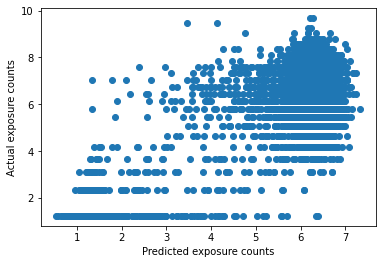

In [8]:
plt.scatter(np.array(predictions)[:, 0], anscombe_transform(test_df[label_cols[0]]))
plt.xlabel("Predicted exposure counts")
plt.ylabel("Actual exposure counts")

Text(0, 0.5, 'Actual outcome counts')

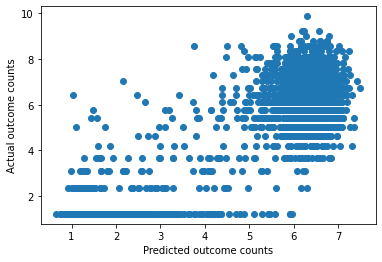

In [10]:
plt.scatter(np.array(predictions)[:, 1], anscombe_transform(test_df[label_cols[1]]))
plt.xlabel("Predicted outcome counts")
plt.ylabel("Actual outcome counts")

# Generating a variants test set

In [13]:
test_sim_data = synthetic.read_simdata_file(raw_simulation_data_fpath)

In [102]:
import editdistance
variants_test_set = {}

nts_to_ints = { 'A':0, 'C':1, 'G':2, 'T':3 } 
ints_to_nts = {i: nt for nt, i in nts_to_ints.items()} 

def mutate_nt(nt):
     return ints_to_nts[(nts_to_ints[nt] + np.random.choice([1, 2, 3])) % 4]

def mutate_sequence(seq, embedding):
    start_pos = embeddings[0].startPos
    embedded_seq = embeddings[0].what.string
    mutation_pos = start_pos + np.random.choice(np.arange(len(embedded_seq)))
    new_nt = mutate_nt(sequence[mutation_pos])      
    new_sequence = sequence[:mutation_pos] + new_nt + sequence[mutation_pos+1:]
    return new_sequence

zipped_sim_data = zip(test_sim_data.sequences, test_sim_data.labels, test_sim_data.embeddings)
for i, (sequence, labels, embeddings) in enumerate(zipped_sim_data):    # One of two motifs embedded
    if len(embeddings) == 1:
        new_sequence = mutate_sequence(sequence, embeddings[0])
        assert new_sequence not in variants_test_set
        assert editdistance.eval(sequence, new_sequence) == 1
        variants_test_set[new_sequence] = i
    elif len(embeddings) == 3:
        new_sequence = mutate_sequence(mutate_sequence(sequence, embeddings[0]), embeddings[1])
        assert new_sequence not in variants_test_set
        assert editdistance.eval(sequence, new_sequence) == 1
        variants_test_set[new_sequence] = i
    else:
        assert len(embeddings) == 0

In [108]:
example_variant = "CTAATACCAACTCACAGCAGATCAGAACACACCAACTGAAAATACGAGTTCCAGAGTTGGGAGAGTAATGGGTGCAGTATACTTTTCCAGATGGCACCTA"
test_df.iloc[1]

sequences     CTAATACCAACTCACAGCAGATAAGAACACACCAACTGAAAATACG...
labels_exp                                                    0
labels_out                                                    0
Name: 1, dtype: object